# 📊 Task 2.2: Sensor-Specific EDA

**Objective**: Analyze the distributions, sampling rates, and quality of the primary passive sensors.

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style for better aesthetics
sns.set_theme(style="whitegrid", palette="viridis", context="talk")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

# Data path
DATA_DIR = Path("../../data/raw/dataset")

## 2. Activity Data Analysis
**File**: `activity.csv`
**Inference**: Stationary (0), Walking (1), Running (2), Unknown (3)
**Questions**:
- What is the distribution of activity types?
- How much data is missing (duty cycling)?
- Are there daily patterns?

Activity Columns: ['timestamp', 'activity inference']
Activity Data Shape: (461991, 1)
                     activity inference
timestamp                              
2013-03-27 04:00:01                   0
2013-03-27 04:00:04                   0
2013-03-27 04:00:07                   0
2013-03-27 04:00:09                   0
2013-03-27 04:03:12                   0


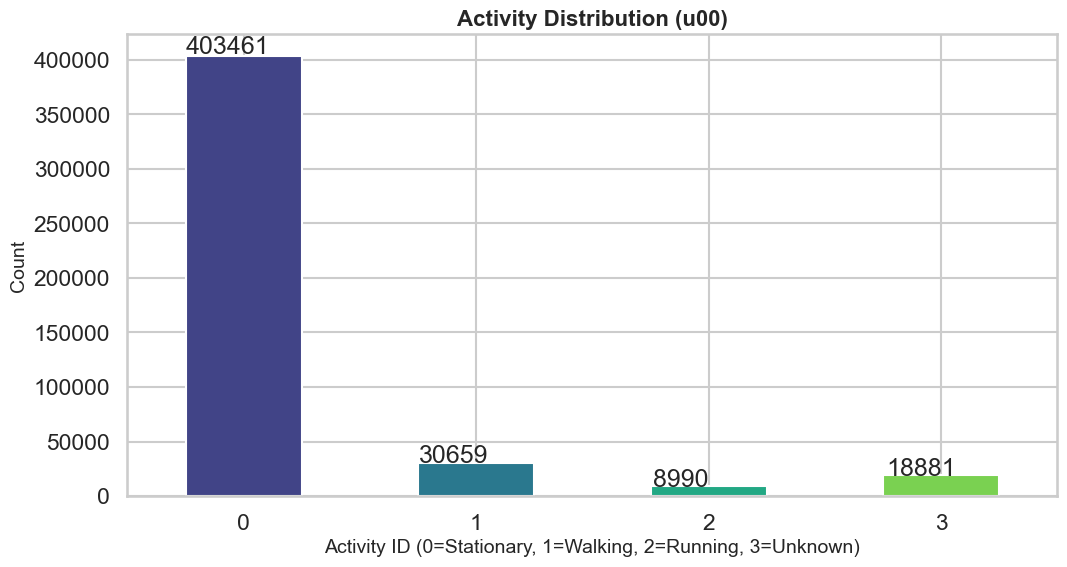

In [2]:
# Load activity data for a sample participant (u00)
activity_path = DATA_DIR / "sensing/activity/activity_u00.csv"
if activity_path.exists():
    try:
        # Use index_col=False to handle potential trailing commas
        activity_df = pd.read_csv(activity_path, index_col=False)
        # Clean column names
        activity_df.columns = activity_df.columns.str.strip()
        print("Activity Columns:", activity_df.columns.tolist())
        
        # Convert timestamp
        activity_df['timestamp'] = pd.to_datetime(activity_df['timestamp'], unit='s', errors='coerce')
        activity_df.dropna(subset=['timestamp'], inplace=True)
        activity_df.set_index('timestamp', inplace=True)
        
        print(f"Activity Data Shape: {activity_df.shape}")
        print(activity_df.head())
        
        # Plot activity distribution
        if 'activity inference' in activity_df.columns:
            plt.figure(figsize=(12, 6))
            ax = activity_df['activity inference'].value_counts().sort_index().plot(kind='bar', color=sns.color_palette("viridis", 4))
            plt.title("Activity Distribution (u00)", fontweight='bold')
            plt.xlabel("Activity ID (0=Stationary, 1=Walking, 2=Running, 3=Unknown)")
            plt.ylabel("Count")
            plt.xticks(rotation=0)
            
            # Add labels
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
                
            plt.show()
        else:
            print("Column 'activity inference' not found.")
            
    except Exception as e:
        print(f"Error loading activity data: {e}")
else:
    print(f"File not found: {activity_path}")

## 3. Audio / Conversation Analysis
**File**: `conversation.csv`
**Questions**:
- What is the average duration of conversations?
- How does conversation frequency change by time of day?

Conversation Columns: ['start_timestamp', 'end_timestamp']
Conversation Data Shape: (2111, 3)
Average Duration: 760.11 seconds


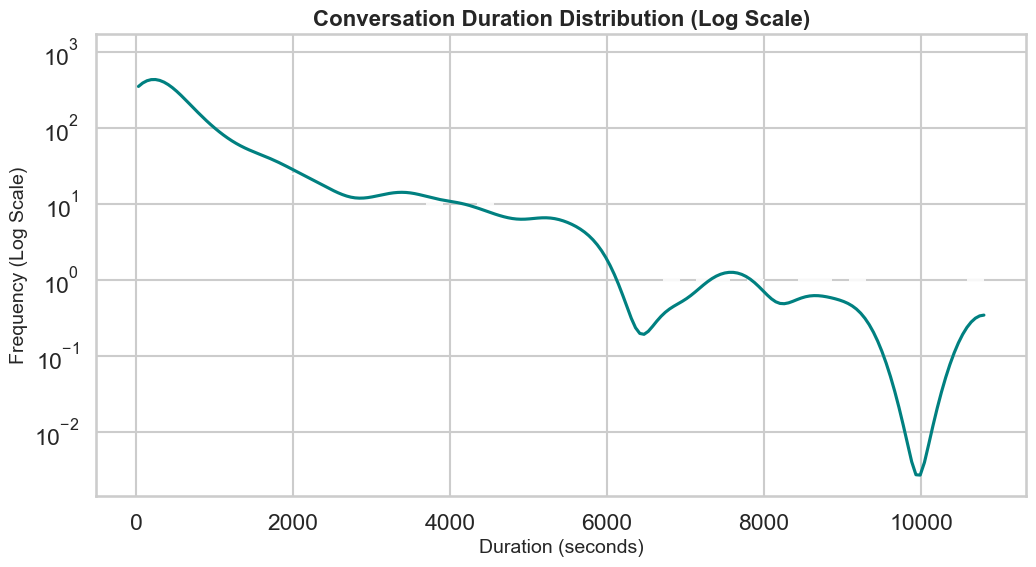

In [3]:
# Load conversation data for u00
conv_path = DATA_DIR / "sensing/conversation/conversation_u00.csv"
if conv_path.exists():
    try:
        # Use index_col=False
        conv_df = pd.read_csv(conv_path, index_col=False)
        conv_df.columns = conv_df.columns.str.strip()
        print("Conversation Columns:", conv_df.columns.tolist())
        
        conv_df['start_timestamp'] = pd.to_datetime(conv_df['start_timestamp'], unit='s', errors='coerce')
        conv_df['end_timestamp'] = pd.to_datetime(conv_df['end_timestamp'], unit='s', errors='coerce')
        
        # Calculate duration
        conv_df['duration'] = (conv_df['end_timestamp'] - conv_df['start_timestamp']).dt.total_seconds()
        
        print(f"Conversation Data Shape: {conv_df.shape}")
        print(f"Average Duration: {conv_df['duration'].mean():.2f} seconds")
        
        # Plot duration distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(conv_df['duration'], bins=50, log_scale=(False, True), color='teal', kde=True)
        plt.title("Conversation Duration Distribution (Log Scale)", fontweight='bold')
        plt.xlabel("Duration (seconds)")
        plt.ylabel("Frequency (Log Scale)")
        plt.show()
    except Exception as e:
        print(f"Error loading conversation data: {e}")
else:
    print(f"File not found: {conv_path}")

## 4. Location Analysis (GPS)
**File**: `gps.csv`
**Questions**:
- What is the spatial coverage?
- Can we identify "Home" vs "Campus"?

GPS Columns: ['time', 'provider', 'network_type', 'accuracy', 'latitude', 'longitude', 'altitude', 'bearing', 'speed', 'travelstate']
First few rows:
         time provider network_type  accuracy   latitude  longitude  \
0  1364356963  network         wifi      24.0  43.759135 -72.329240   
1  1364358144      gps          NaN      22.0  43.759503 -72.329018   
2  1364359364  network         wifi      23.0  43.759134 -72.329238   
3  1364360563  network         wifi      25.0  43.759135 -72.329240   
4  1364361763  network         wifi      25.0  43.759135 -72.329240   

     altitude  bearing  speed travelstate  
0    0.000000      0.0    0.0  stationary  
1  250.899994      0.0    0.0         NaN  
2    0.000000      0.0    0.0  stationary  
3    0.000000      0.0    0.0  stationary  
4    0.000000      0.0    0.0  stationary  
GPS Data Shape: (4316, 10)


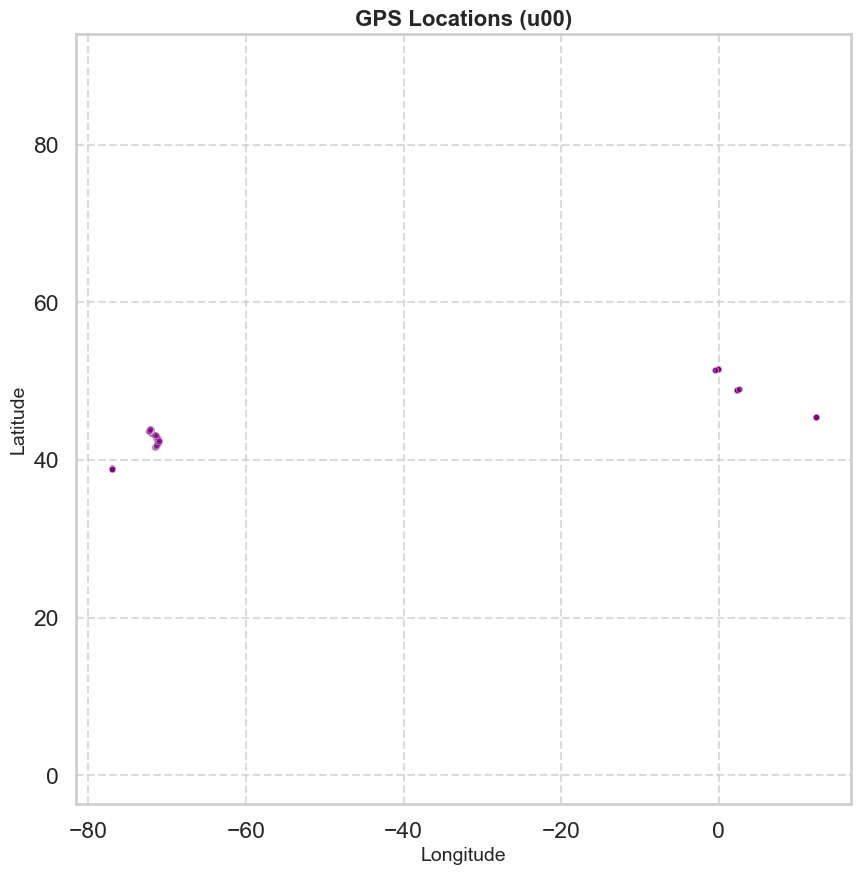

In [4]:
# Load GPS data for u00
gps_path = DATA_DIR / "sensing/gps/gps_u00.csv"
if gps_path.exists():
    try:
        # Use index_col=False to handle potential trailing commas causing column shift
        gps_df = pd.read_csv(gps_path, index_col=False)
        gps_df.columns = gps_df.columns.str.strip()
        print("GPS Columns:", gps_df.columns.tolist())
        print("First few rows:")
        print(gps_df.head())
        
        gps_df['time'] = pd.to_datetime(gps_df['time'], unit='s', errors='coerce')
        
        # Check for NaT
        n_nat = gps_df['time'].isna().sum()
        if n_nat > 0:
            print(f"Warning: {n_nat} rows have invalid timestamps and will be dropped.")
            gps_df.dropna(subset=['time'], inplace=True)
        
        print(f"GPS Data Shape: {gps_df.shape}")
        
        # Scatter plot of location (Latitude vs Longitude)
        plt.figure(figsize=(10, 10))
        sns.scatterplot(data=gps_df, x='longitude', y='latitude', alpha=0.3, s=20, color='purple')
        plt.title("GPS Locations (u00)", fontweight='bold')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.axis('equal')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    except Exception as e:
        print(f"Error loading GPS data: {e}")
else:
    print(f"File not found: {gps_path}")